In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
from helper import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import umap

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [3]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

In [4]:
raw_data = pd.read_csv("data/heart.csv")
original_data = raw_data.drop(columns=["target"])
training_labels = raw_data["target"]
raw_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 25, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units = 15, activation="elu",
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=25, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [6]:
## Need to define a scaling function that ignores categorical values...?

In [7]:
nn = build_dnn(num_features=original_data.shape[1])
nn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                350       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 52        
Total params: 1,052
Trainable params: 1,052
Non-trainable params: 0
___________________

Using TensorFlow backend.


In [8]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=15,
                    min_dist=0)

In [9]:
# Separating a hold out set that will be used for validation later
X_train, y_train, X_valid, y_valid = split_valid(original_data, training_labels, valid_size=0.1)    

pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer)

pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Instructions for updating:
Use tf.cast instead.
Fold: 0 -> Loss:0.428, Acc:0.8910
Prediction Accuracy
28/28 [==============================] - 0s 1ms/step
Scores on data set: loss=0.753 accuracy=0.6786
Fold Correct: 19
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Running worker: 1
Fold: 1 -> Loss:0.450, Acc:0.8647
Prediction Accuracy
28/28 [==============================] - 0s 18us/step
Scores on data set: loss=0.435 accuracy=0.8214
Fold Correct: 23
Running worker: 2
Fold: 2 -> Loss:0.489, Acc:0.8684
Prediction Accuracy
28/28 [==============================] - 0s 21us/step
Scores on data set: loss=0.428 accuracy=0.8214
Fold Correct: 23
Running worker: 3
Fold: 3 -> Loss:0.444, Acc:0.8684
Prediction Accuracy
28/28 [==============================] - 0s 23us/step
Scores on data set: loss=0.301 accuracy=0.9286
Fold Correct: 26
Running worker: 4
Fold: 4 -> Loss:0.432, Acc:0.8647
Prediction Accuracy
27/27 [=====

Confusion matrix, without normalization
[[0.7983871  0.2016129 ]
 [0.12837838 0.87162162]]


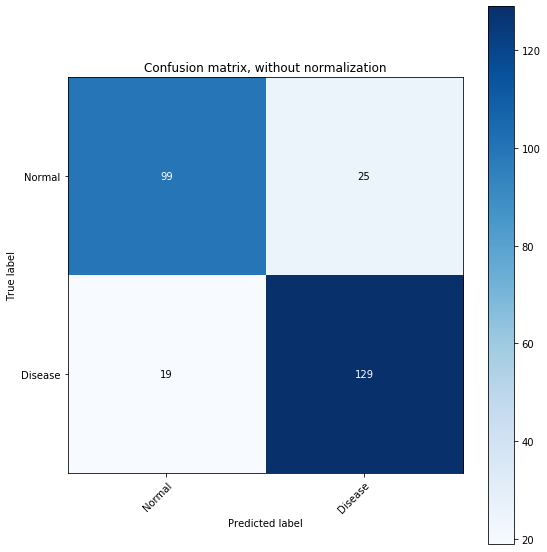

In [10]:
plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

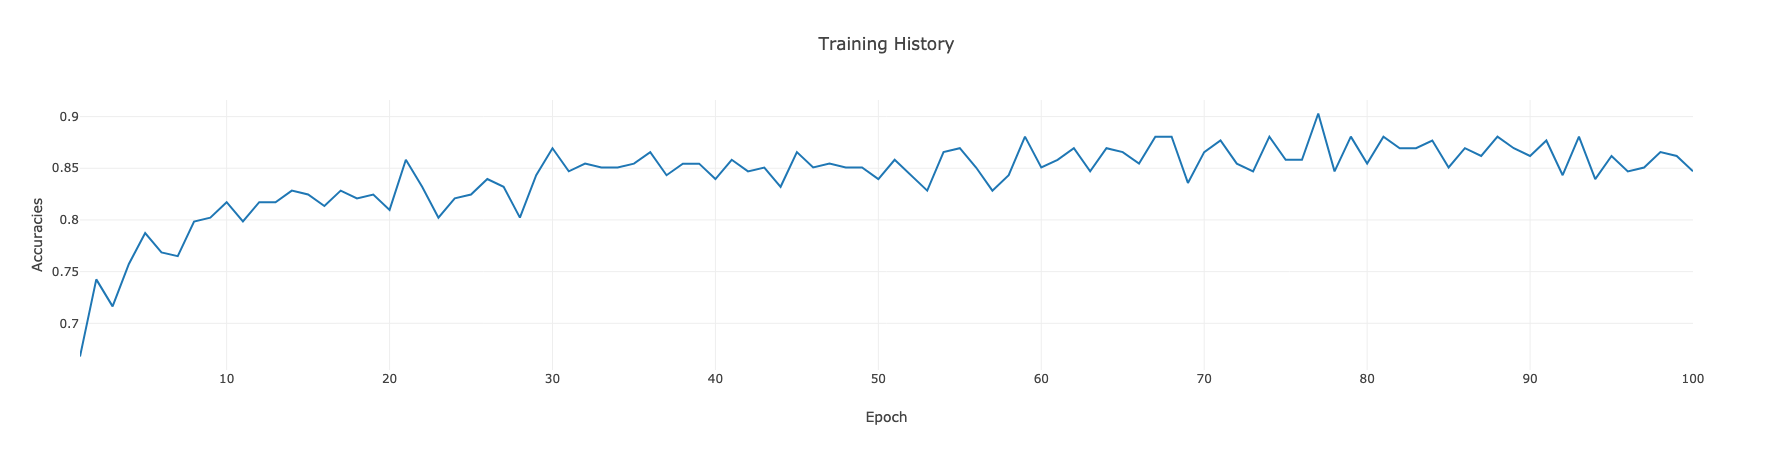

In [11]:
from plotly.offline import iplot
from plotly.offline import plot

accs = nn.history.history["acc"]
loss = nn.history.history["loss"]

accs_plot = go.Scatter(
    x=[x for x in range(1,len(accs)+1)],
    y=accs,
    mode="lines",
    name="line plot"
)

data = [accs_plot]

layout = go.Layout(
    title= "Training History",
    yaxis= {"title":"Accuracies"},
    xaxis={"title":"Epoch"}
)

fig = go.Figure(data=data, layout=layout)


iplot(fig)

In [12]:
# min_cluster_sizes=range(10,17,1)
pipeline.train_clusterer(plot=False)

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:725: NumbaWarning:

Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:734

Minimum Size:
Clusters                  (12, 12)
Noise                     (12, 12)
Halkidi                   (12, 12)
Halkidi-Filtered Noise    (12, 12)
dtype: object


,Clusters,Noise,Halkidi,Halkidi-Filtered Noise
"(12, 12)",4,0.0,0.14239,0.14239
"(13, 12)",4,0.0,0.14239,0.14239
"(13, 13)",4,0.0,0.14239,0.14239
"(14, 12)",4,0.0,0.14239,0.14239
"(14, 13)",4,0.0,0.14239,0.14239
"(14, 14)",4,0.0,0.14239,0.14239
"(15, 12)",4,0.0,0.14239,0.14239
"(15, 13)",4,0.0,0.14239,0.14239
"(15, 14)",4,0.0,0.14239,0.14239
"(15, 15)",4,0.0,0.14239,0.14239


In [13]:
pd.Series(pipeline.clusterer.labels_).value_counts()

2    38
1    34
3    32
0    25
dtype: int64

In [14]:
samples, cluster_labels = pipeline.get_validation_clusters()

Loading LRP Analyzers...
Done!


In [15]:
pd.Series(cluster_labels).value_counts()

1    14
2     1
dtype: int64

## Plotting Testing LRP

In [16]:
training_lrp = pipeline.training_lrp
val_lrp = pipeline.val_set_lrp

In [17]:
embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=10,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline.fit(training_lrp)


# reducer = umap.UMAP(random_state=42,
#                     n_components = 2,
#                     n_neighbors=10,
#                     min_dist=0)

# embedding = reducer.fit_transform(training_lrp)

# emb2d = go.Scatter(
#     x=embedding[:,0],
#     y=embedding[:,1],
#     mode="markers"
# )

# layout = go.Layout(
#     title= "2D LRP Embedding"
# )

# data=[emb2d]

# fig = go.Figure(data=data, layout=layout)
# iplot(fig)



embedding = embedding_pipeline.transform(training_lrp)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Training",
    marker=dict(
        size=5,
        color=pipeline.clusterer.labels_,
        colorscale="Rainbow",
        opacity=0.8
    ),
    text=pipeline.clusterer.labels_
)

val_3d_embedding = embedding_pipeline.transform(val_lrp)

val_emb3d = go.Scatter3d(
    x=val_3d_embedding[:,0],
    y=val_3d_embedding[:,1],
    z=val_3d_embedding[:,2],
    name="Validation",
    mode="markers",
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8
#         showscale=True
    ),
    text = cluster_labels
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=1000,
    paper_bgcolor='#F5F5F5'
)


data=[emb3d, val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-3d-4subheart.html')

## Calculating Entropy

In [19]:
relevance_embedding = embedding
relevance_embedding.shape

(129, 3)

In [45]:
from scipy.stats import entropy
from sklearn.neighbors import KernelDensity

    
nsamples = len(relevance_embedding)
nbins = 15

nbins  = 10
xedges = np.linspace(0,1,nbins+1)
yedges = np.linspace(0,1,nbins+1)
zedges = np.linspace(0,1,nbins+1)

axes_ = [x.ravel() for x in np.meshgrid(xedges,yedges,zedges)]

grid = np.array([x for x in zip(*axes_)])

# grid, edges = np.histogramdd(relevance_embedding, bins=nbins)
# densities = (grid/nsamples).flatten()

In [47]:
kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(relevance_embedding)
train_densities = kde.score_samples(relevance_embedding)
densities = np.exp(kde.score_samples(grid))

In [48]:
# pd.DataFrame(densities[densities > 0]).plot()
emb3d["marker"]["color"] = train_densities
emb3d["marker"]["showscale"]=True
emb3d["marker"]["colorscale"]="Reds"

data=[emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-densities.html')

In [49]:
entropy(densities)

7.190712870387177

In [34]:
%%time

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                              covariance_type=cv_type)
        gmm.fit(relevance_embedding)
        bic.append(gmm.bic(relevance_embedding))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
best_gmm.fit(relevance_embedding)

CPU times: user 86.9 ms, sys: 3.28 ms, total: 90.2 ms
Wall time: 92.5 ms


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [35]:
gmm_densities = np.exp(best_gmm.score_samples(relevance_embedding))

emb3d["marker"]["color"] = gmm_densities
emb3d["marker"]["showscale"]=True
emb3d["marker"]["colorscale"]="Reds"

data=[emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-densities.html')
print("Entropy:", entropy(gmm_densities))

Entropy: 3.3257714312813906


In [36]:
best_gmm.score_samples(relevance_embedding)

array([ 5.19959997,  6.76858605,  5.83743125,  5.93451889,  6.68535842,
        5.99231411,  4.50941575,  5.18510925,  5.86742232,  5.84083273,
        7.37555245,  6.65155685,  6.40745629,  6.66202773,  6.71170618,
        5.65080996,  6.42000775,  7.17715937,  7.1378556 ,  6.38233266,
        6.36283861,  5.7300338 ,  4.43690415,  6.04676917,  7.51866275,
        6.96558711,  4.69646845,  7.71409922,  7.00734814,  7.31944856,
        5.50606626,  6.4205618 ,  7.35651087,  7.23305391,  5.01112937,
        6.46288775,  6.06137745,  5.98073946,  7.41519002,  6.17216752,
        6.39897733,  7.06317286,  6.76829893,  6.88274945,  6.93025452,
        6.23837293,  5.48000256,  6.95742097,  7.64799989,  6.28782053,
        7.93694479,  5.33792257,  7.40293577,  6.38290047,  7.66140422,
        6.82983686,  7.51450846,  5.9314558 ,  7.28296627,  6.77020051,
        6.58883591,  7.58777472,  6.66566591,  6.52127525,  7.59873979,
        4.51349668,  7.5268705 ,  7.08595958,  5.66357528,  6.26